In [1]:
import pandas as pd
import numpy as np
from joblib import dump
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
#
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
# from sklearn.metrics import accuracy_score, precision_recall_curve, plot_roc_curve, plot_confusion_matrix
# from sklearn.metrics import SCORERS, plot_precision_recall_curve
from sklearn.metrics import *
from sklearn.utils import parallel_backend
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

from matplotlib import pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Constants
SEED = 87654

# Functions
def post_est(est, preds, x_test, y_test, plots = True):
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))
    print('ROC AUC score:', round(roc_auc_score(y_test, preds), 2))
    print('Avg precision score:', round(average_precision_score(y_test, preds), 2))
    print('Specificity:', round(tn / (tn + fp), 2))
    print('Sensititity (recall):', round(tp / (tp + fn), 2))
    # print(round((tn, fp, fn, tp) / (tn+fp+fn+tp), 2))

    if(plots == True):
        plot_confusion_matrix(est, x_test, y_test, normalize = 'all')
        plot_roc_curve(est, x_test, y_test)
        plot_precision_recall_curve(est, x_test, y_test)

In [2]:
%pwd

'/Volumes/GoogleDrive/My Drive/AXDD/Non-Service Work/Innovation/Retention Task Force/rtf_freefall/OMAD_adverse_outcome_mod/src_py'

In [3]:
data = pd.read_csv('../data/transformed-data-to-py.csv', na_values=['NA', 'NaN', 'Inf', '-Inf'])
cat_var_list = []
with open('../data/cat-var-list.txt', 'r') as f:
    for line in f.read().splitlines():
        cat_var_list.append(line)

if 'Unnamed: 0' in data.columns:
    data.drop(columns = 'Unnamed: 0', inplace = True)

data.dropna(subset = ['Y'], inplace = True)   

# def recode_cats(df, var_list):
#     for x in var_list:
#         df = pd.concat([df, pd.get_dummies(df[x],
#                                            prefix = x,
#                                            dummy_na = False,
#                                            drop_first = True)],  # check this opt depending on model(s)
#                       axis = 1).drop([x], axis = 1)
#     return(df)
    
# data = recode_cats(data, cat_var_list)
id_vars = ['system_key', 'yrq']
target = 'Y'
x_vars = [x for x in data.columns if x not in [target]]
x_vars = [x for x in x_vars if x not in id_vars]

x_train, x_test, y_train, y_test = train_test_split(data[x_vars], 
                                                    data[target],
                                                    test_size = 0.25, 
                                                    random_state = SEED, 
                                                    stratify = data[target])

In [4]:
# already have `cat_var_list`
num_var_list = ['tenth_day_credits', 'num_courses', 'pts',
                'attmp', 'nongrd', 'qgpa', 'tot_creds',
                'cum.pts', 'cum.attmp', 'cum.gpa', 'best_satr_v', 
                'best_satr_m', 'best_satr_c', 'age', 'trans_gpa',
                'high_sch_gpa', 'major.change.count', 'n.major.courses',
                'csum.major.courses', 'avg.class.size', 'sum.fees',
                'csum.rep.courses', 'csum.w', 'csum.alt.grading', 
                'stem.courses', 'stem.credits', 'avg.stem.grade',
                'csum.stem.courses', 'csum.stem.credits', 'ft.creds.over',
                'rundiff']

cat_tran = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent', fill_value = -1)),
    ('onehot', OneHotEncoder(drop = None, handle_unknown = 'ignore'))])

num_tran = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy = 'mean'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_tran, num_var_list),
        ('cat', cat_tran, cat_var_list)])

# col_tran = make_column_transformer(
#         (StandardScaler(), ['tenth_day_credits', 'num_courses', 'pts',
#                             'attmp', 'nongrd', 'qgpa', 'tot_creds',
#                             'cum.pts', 'cum.attmp', 'cum.gpa', 'best_satr_v', 
#                             'best_satr_m', 'best_satr_c', 'age', 'trans_gpa',
#                             'high_sch_gpa', 'major.change.count', 'n.major.courses',
#                             'csum.major.courses', 'avg.class.size', 'sum.fees',
#                             'csum.rep.courses', 'csum.w', 'csum.alt.grading', 
#                             'stem.courses', 'stem.credits', 'avg.stem.grade',
#                             'csum.stem.courses', 'csum.stem.credits', 'ft.creds.over',
#                             'rundiff']), # 'ic_tot', 
#     remainder = 'passthrough',
#     n_jobs = -1)

In [5]:
nn_steps = [# ('cat_transformer', cat_transformer),
            # ('scaler', col_tran),
            # ('cat_impute', cat_impute),
            # ('ohe', cat_ohe),
            # ('impute', IterativeImputer()),
            # ('impute', SimpleImputer(strategy = 'mean')),
            # in my simple tests on a small slice of data mean imputation outperformed multiple imputation
            # with the advantage of being massively faster
            ('preprocessor', preprocessor),
            ('nnet', MLPClassifier())]
nn_pipe = Pipeline(nn_steps, verbose = True)

In [6]:
# cv5 = cross_val_score(nn_pipe, 
#                       x_train, 
#                       y_train, 
#                       cv = 5, 
#                       scoring = 'f1_macro', 
#                       n_jobs = -1, 
#                       verbose = 2)

# cv5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.3min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


array([0.80715665, 0.80533844, 0.80632524, 0.80770303, 0.80644794])

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   2.3s
[Pipeline] .............. (step 2 of 2) Processing nnet, total= 2.4min


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True)),
                                                                  ('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy

[[34400  4381]
 [ 6289 19727]]
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87     38781
         1.0       0.82      0.76      0.79     26016

    accuracy                           0.84     64797
   macro avg       0.83      0.82      0.83     64797
weighted avg       0.83      0.84      0.83     64797

ROC AUC score: 0.82
Avg precision score: 0.72
Specificity: 0.89
Sensititity (recall): 0.76


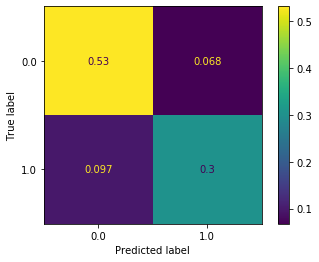

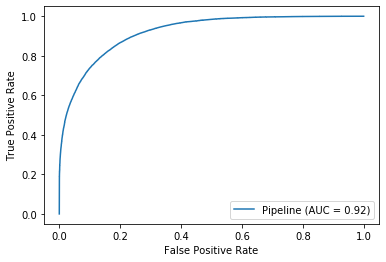

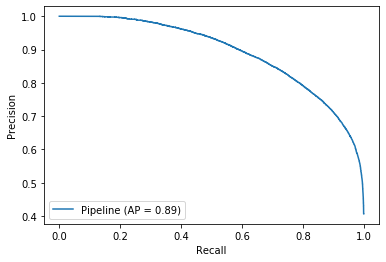

In [6]:
with parallel_backend('loky'):
    nn_pipe.set_params(nnet__alpha = .0001,
                       nnet__activation = 'logistic',  # {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
                       nnet__early_stopping = True,
                       nnet__hidden_layer_sizes = (200, 200, 200),
                       nnet__max_iter = 500,
                       nnet__verbose = False).fit(x_train, y_train)

    # mlp = MLPClassifier(hidden_layer_sizes = (236, 236, 236), max_iter = 500)

# joblib.dump(pipe, 'mods/fitted-test-nnet-pipe.sav')

preds = nn_pipe.predict(x_test)
predsa = nn_pipe.predict_proba(x_test)
resid = y_test - preds

post_est(nn_pipe, preds, x_test, y_test)

In [7]:
dump(nn_pipe, '../models/fitted-nnet-activation-logistic.joblib')

['../models/fitted-nnet-activation-logistic.joblib']

In [34]:
# new_data = pd.read_csv('../data/new-data-to-predict.csv', na_values=['NA', 'NaN', 'Inf', '-Inf'])

# # new_data = recode_cats(new_data, cat_var_list)
# new_x_vars = [x for x in new_data.columns if x not in [target]]
# new_x_vars = [x for x in new_x_vars if x not in id_vars]
# new_x = new_data[new_x_vars]
# # missing_vars = [x for x in x_vars if x not in new_x_vars]
# # missing_vars = dict((x, np.nan) for x in missing_vars)

# new_preds = nn_pipe.predict(new_x)
# new_predsa = nn_pipe.predict_proba(new_x)
# plt.hist(new_predsa[:,1])